In [11]:
# for debug
%reload_ext autoreload
%autoreload 2

In [12]:
from pascode import PASCode
import scanpy as sc
import torch
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
import random
import anndata
import numpy as np
import pandas as pd

torch.manual_seed(2022)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

device = torch.device('cpu')

In [4]:
############################################################################### 
################################### Data reading ##############################
###############################################################################
print("Reading data...")
gxp = pd.read_csv('/home/athan/data_PASCode/mit_gxp_mic.csv')
lab = pd.read_csv('/home/athan/data_PASCode/mit_lab_mic.csv')
print('Reading complete.')

Reading data...
Reading complete.


In [5]:
############################################################################### 
################################### Data preprocessing ########################
###############################################################################
print('Preprocessing data...')
gxp = gxp.iloc[:, 1:]
lab.index=lab.TAG
# phenotype is AD(1)/CTL(0)
lab['AD'] = lab.diagnosis
lab.AD = lab.AD.replace({'AD':1, 'CTL':0})
# select Highly Variable Genes from gene expression data
print("Selecting HVGs...")
agxp = anndata.AnnData(gxp)
sc.pp.highly_variable_genes(agxp, min_mean=.0125, max_mean=3, min_disp=.25)
gxp = gxp.loc[:, agxp.var.highly_variable]
# scaling
print("Scaling...")
scaler = preprocessing.StandardScaler().fit(gxp)
scaled_features = scaler.transform(gxp)
X = pd.DataFrame(scaled_features, columns=gxp.columns, index=gxp.index)
print("Data preprocessing completed.")

Preprocessing data...
Selecting HVGs...
Scaling...
Data preprocessing completed.


In [6]:
############################################################################### 
######################### train, test, validation sets ########################
###############################################################################
def get_id_pheno(lab, pheno_name):
    """
    Get subjectID/sampleID - phenotype label indexed dataframe.
    """
    group = lab.groupby(['subjectID', pheno_name]).size()
    group = group[group>0] # filtering
    id_pheno = group.index.to_frame()
    return id_pheno

# get sample IDs and phenotypes (list)
id_pheno = get_id_pheno(lab, pheno_name='AD')
# validation set: 8 donors with subjectID and AD labels
val_size = 4
val_set = pd.DataFrame({
    'subjectID':random.sample(list(id_pheno[id_pheno['AD']==0].subjectID), val_size) 
           + random.sample(list(id_pheno[id_pheno['AD']==1].subjectID), val_size),
    'phenotype':[0]*val_size + [1]*val_size})
# train/test set: 40 donors with subjectID and AD labels
train_test_set = id_pheno[~(id_pheno['subjectID'].isin(val_set['subjectID']))]
X = X[lab['subjectID'].isin(train_test_set['subjectID']).values]
lab = lab[lab['subjectID'].isin(train_test_set['subjectID'])]

In [146]:
############################################################################### 
############################### Cross validation ##############################
############################################################################### 
# prepare data
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_acc = np.array([])
iter_num = 0

for train_index, test_index in skf.split(train_test_set['subjectID'], train_test_set['AD']):
    iter_num += 1
    print('#'*39 + " Fold " + str(iter_num) + ' ' + '#'*39)
    print("Training index:", train_index, "\ntraining index:", test_index)

    train_sample = [train_test_set['subjectID'][i] for i in train_index]
    test_sample = [train_test_set['subjectID'][i] for i in test_index]
    train_filter = lab['subjectID'].isin(train_sample).values
    test_filter = lab['subjectID'].isin(test_sample).values

    X_train = torch.tensor(X.loc[train_filter].values).float().to(device)
    lab_train = lab[train_filter]
    id_train = lab_train['subjectID'].values
    y_train = torch.tensor(lab_train['AD'].values)
    X_test = torch.tensor(X.loc[test_filter].values).float().to(device)
    lab_test = lab[test_filter]
    id_test = lab_test['subjectID'].values
    y_test = torch.tensor(lab_test['AD'].values)
    
    # use model
    psc = PASCode(n_clusters=5)
    psc.train(X_train, y_train, batch_size=128)

    # perforamce
    psc.evaluate(X_train, y_train, id_train, X_test, y_test, id_test)

####################################### Fold 1 #######################################
Training index: [ 3  4  5  7  8 10 11 14 15 17 19 24 25 27 28 29 31 33 35 38] 
training index: [ 0  1  2  6  9 12 13 16 18 20 21 22 23 26 30 32 34 36 37 39]
Pretraining...
epoch 0	 loss=1.0835
epoch 1	 loss=1.0479
epoch 2	 loss=1.0126
epoch 3	 loss=0.8934
epoch 4	 loss=0.7634
epoch 5	 loss=0.6489
epoch 6	 loss=0.6000
Initializing cluster centroids...
Pretraining complete.

Training...
----- 	 ------------ 	 ------------- 	 ------------- 	 ------------
epoch 	 (total) loss 	  cluster loss 	 reconstr loss 	 entropy loss
----- 	 ------------ 	 ------------- 	 ------------  	 ------------
    0 	 0.91640 	 0.02208 	  0.55712 	 0.49596 
    1 	 0.99762 	 0.01695 	  0.55099 	 0.47995 
    2 	 0.87923 	 0.01857 	  0.55370 	 0.40085 
    3 	 0.84368 	 0.01257 	  0.55627 	 0.38099 
    4 	 0.88526 	 0.01357 	  0.55974 	 0.30610 
    5 	 0.80832 	 0.01320 	  0.55214 	 0.33896 
    6 	 0.87067 	 0.01300 	  0.54

# Visualization

## Heatmap on the donor-cluster-fraction matrix

### Training

<AxesSubplot:>

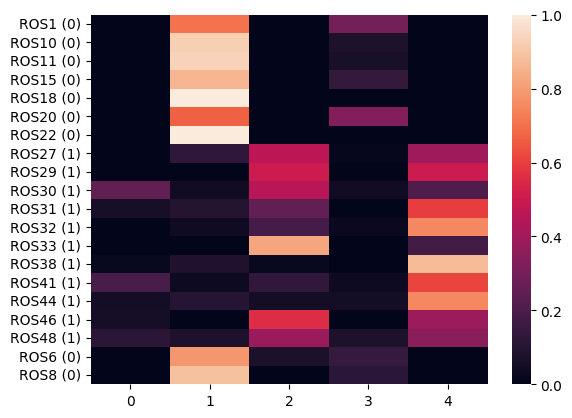

In [106]:
import seaborn as sns

X_new_train = psc.get_donor_cluster_fraction_matrix(X_train, id_train)

new_index = []
for donor in X_new_train.index:
    new_name = donor + ' (' + str(train_test_set.loc[donor].AD.values[0]) + ')'
    new_index.append(new_name)
X_new_train.index = new_index

sns.heatmap(X_new_train)

### Testing

<AxesSubplot:>

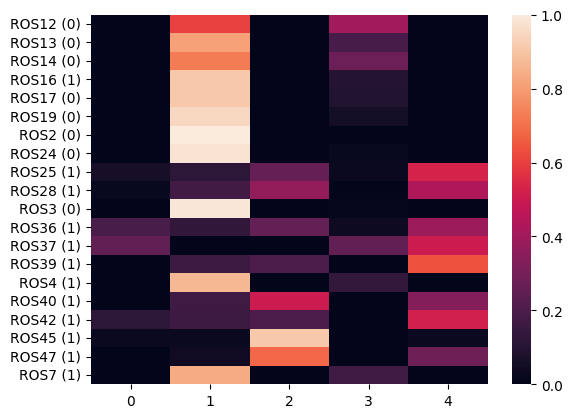

In [107]:
import seaborn as sns

X_new_test = psc.get_donor_cluster_fraction_matrix(X_test, id_test)

new_index = []
for donor in X_new_test.index:
    new_name = donor + ' (' + str(train_test_set.loc[donor].AD.values[0]) + ')'
    new_index.append(new_name)
X_new_test.index = new_index

sns.heatmap(X_new_test)

## tsne in the lab original data 

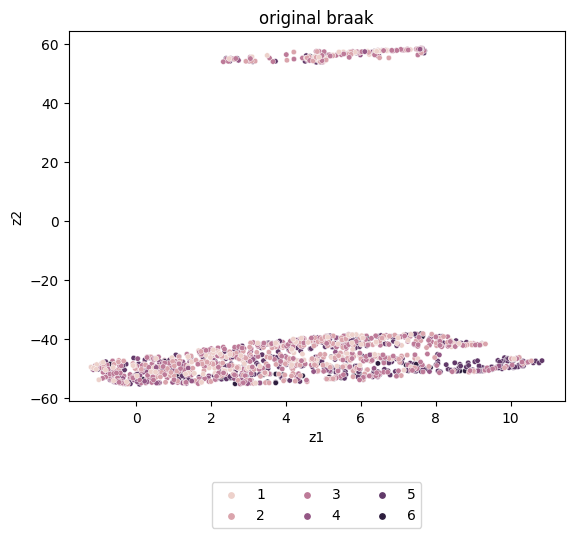

In [108]:
psc.plot_embedding(X=np.vstack([lab.tsne1.values, lab.tsne2.values]).T, y=lab['braaksc.1'].values, label='braak', title='original braak')

## UMAP on both training and testing data

In [109]:
embd_train = psc.get_embedding(X_train, reducer='umap')
embd_test = psc.get_embedding(X_test, reducer='umap')

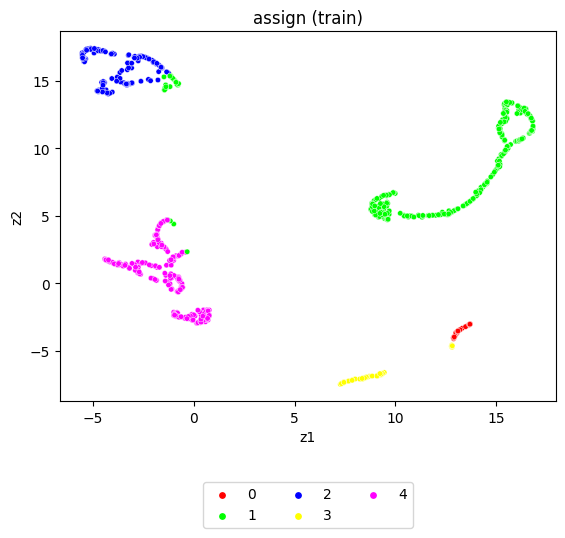

In [110]:
# On training data
lab_train['assign'] = psc.get_assigns(X_train)
psc.plot_embedding(X=embd_train, y=lab_train['assign'].values, label='assign', title='assign (train)', require_distinguishable_colors=True)

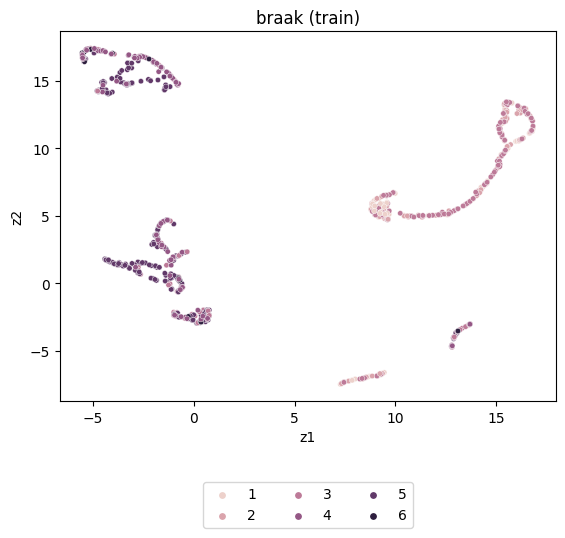

In [111]:
psc.plot_embedding(X=embd_train, y=lab_train['braaksc'].values, label='braak', title='braak (train)', require_distinguishable_colors=False)

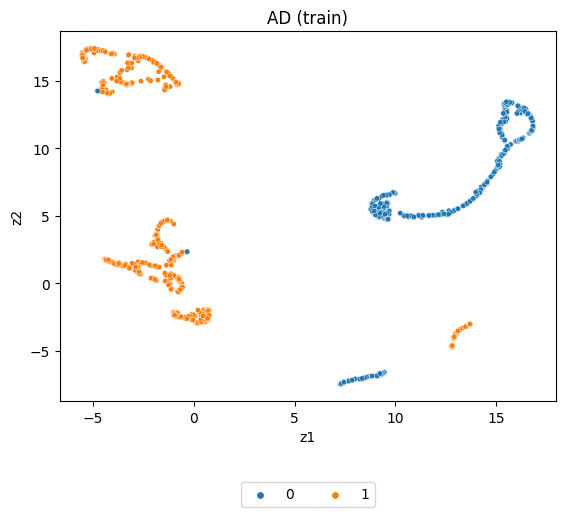

In [112]:
psc.plot_embedding(X=embd_train, y=lab_train['AD'].values, label='AD', title='AD (train)', require_distinguishable_colors=False)

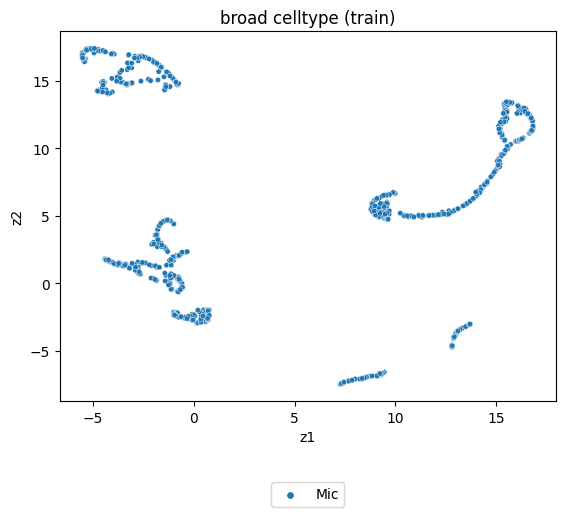

In [113]:
psc.plot_embedding(X=embd_train, y=lab_train['broad.cell.type'].values, label='broad celltype', title='broad celltype (train)', require_distinguishable_colors=False)

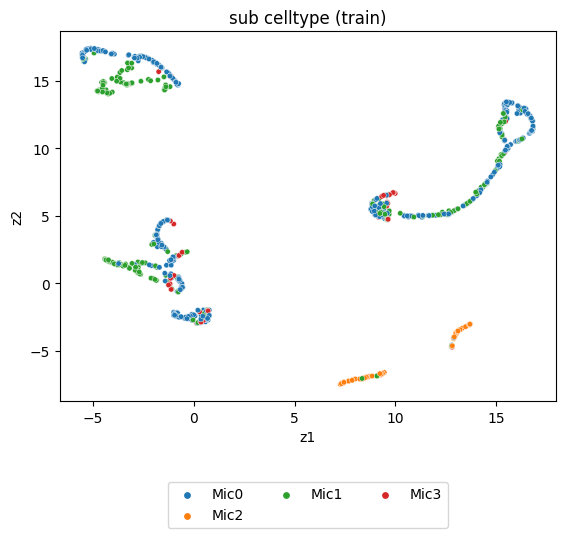

In [114]:
psc.plot_embedding(X=embd_train, y=lab_train['Subcluster'].values, label='subcelltype', title='sub celltype (train)', require_distinguishable_colors=False)

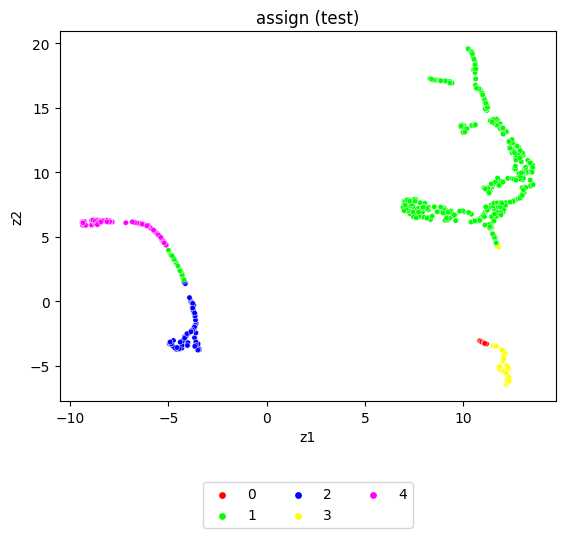

In [115]:
# on test data
lab_test['assign'] = psc.get_assigns(X_test)
psc.plot_embedding(X=embd_test, y=lab_test['assign'].values, label='assign', title='assign (test)', require_distinguishable_colors=True)

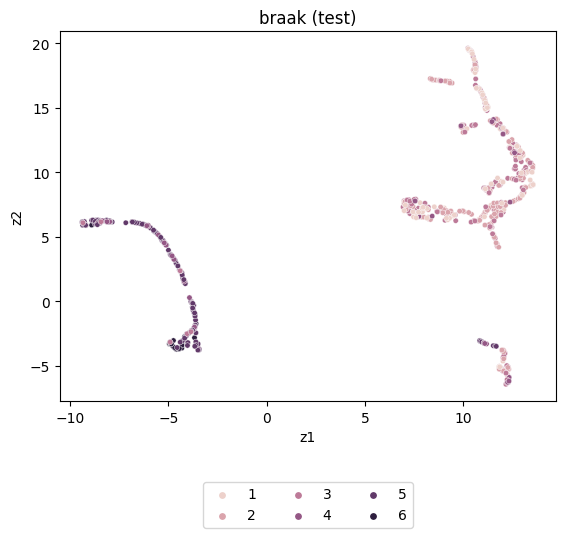

In [116]:
psc.plot_embedding(X=embd_test, y=lab_test['braaksc'].values, label='braak', title='braak (test)', require_distinguishable_colors=False)

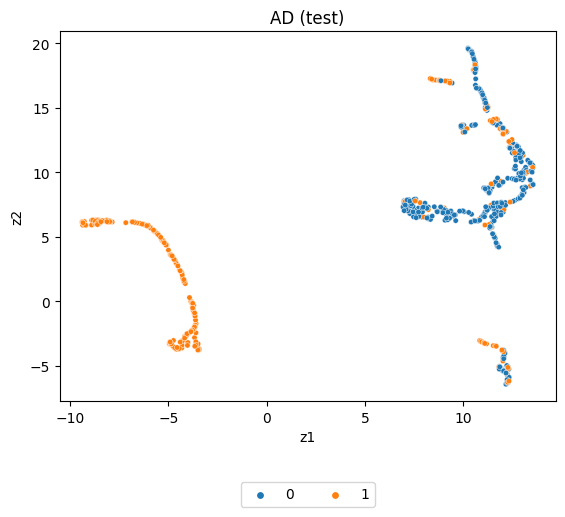

In [117]:
psc.plot_embedding(X=embd_test, y=lab_test['AD'].values, label='AD', title='AD (test)', require_distinguishable_colors=False)

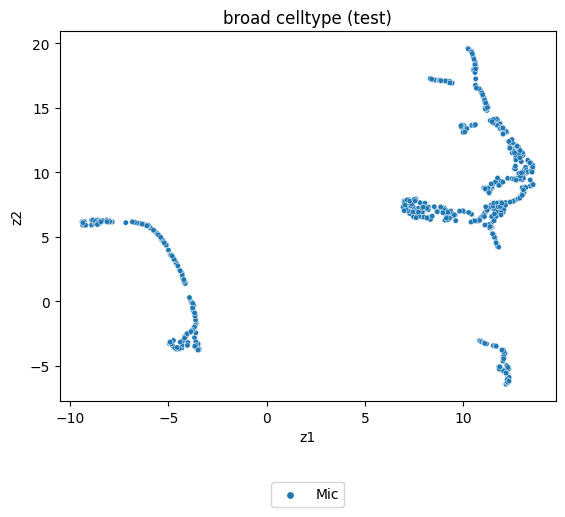

In [118]:
psc.plot_embedding(X=embd_test, y=lab_test['broad.cell.type'].values, label='broad celltype', title='broad celltype (test)', require_distinguishable_colors=False)

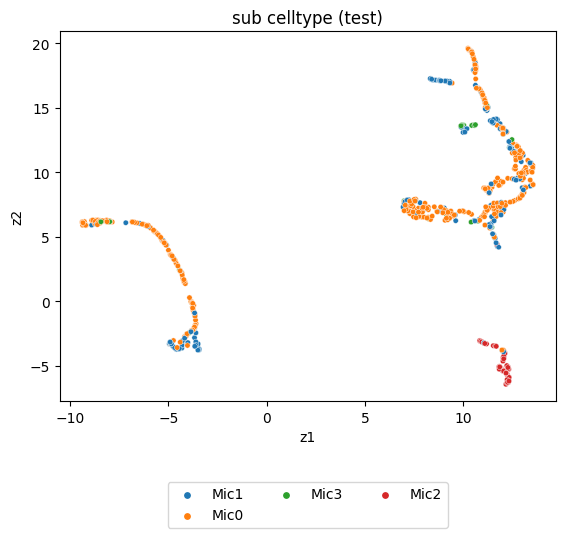

In [119]:
psc.plot_embedding(X=embd_test, y=lab_test['Subcluster'].values, label='subcelltype', title='sub celltype (test)', require_distinguishable_colors=False)